<a href="https://colab.research.google.com/github/dunliangyang2010/AutoKeras/blob/main/Multi_model_digits_breast_cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install autokeras

In [2]:
import tensorflow as tf
import autokeras as ak

# Prepare data
digits: 1,797筆, 8x8圖片
breast_cancer: 569筆, 每筆10個特徵之結構化資料

In [3]:
from sklearn.datasets import load_digits, load_breast_cancer

digits = load_digits()
breast_cancer = load_breast_cancer()

image_data = digits.images
structured_data = breast_cancer.data.astype('float32') # 為對structured_data進行迴歸,故將資料轉為float
classification_target = digits.target
regression_target = breast_cancer.target.astype('float32')

In [4]:
# 將image data裁切,使之與breast_cancer長度一致,有一對一對應
image_data = image_data[:regression_target.size]
classification_target = classification_target[:regression_target.size]

print(image_data.shape)
print(structured_data.shape)

(569, 8, 8)
(569, 30)


In [5]:
# General Search
multi_model = ak.AutoModel( 
    inputs=[
        ak.ImageInput(), 
        ak.StructuredDataInput()
    ], 
    outputs=[
        ak.ClassificationHead(),
        ak.RegressionHead(),
    ], 
    max_trials=1, overwrite=True)

multi_model.fit( 
    [image_data, structured_data], 
    [classification_target, regression_target], 
    epochs=1)

# 可觀察訓練過程中loss可分為: total loss, classification layer loss, regression layer loss
# 且兩子模型輸出合併方式為concatenate

Trial 1 Complete [00h 00m 54s]
val_loss: 46.62902069091797

Best val_loss So Far: 46.62902069091797
Total elapsed time: 00h 00m 54s
INFO:tensorflow:Oracle triggered exit
18/18 [==============================] - 52s 3s/step - loss: 27.4575 - classification_head_1_loss: 13.7479 - regression_head_1_loss: 13.7096 - classification_head_1_accuracy: 0.1072 - regression_head_1_mean_squared_error: 13.7096
INFO:tensorflow:Assets written to: ./auto_model/best_model/assets


In [6]:
model = multi_model.export_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 8, 8)]       0           []                               
                                                                                                  
 cast_to_float32 (CastToFloat32  (None, 8, 8)        0           ['input_1[0][0]']                
 )                                                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 30)]         0           []                               
                                                                                                  
 expand_last_dim (ExpandLastDim  (None, 8, 8, 1)     0           ['cast_to_float32[0][0]']    

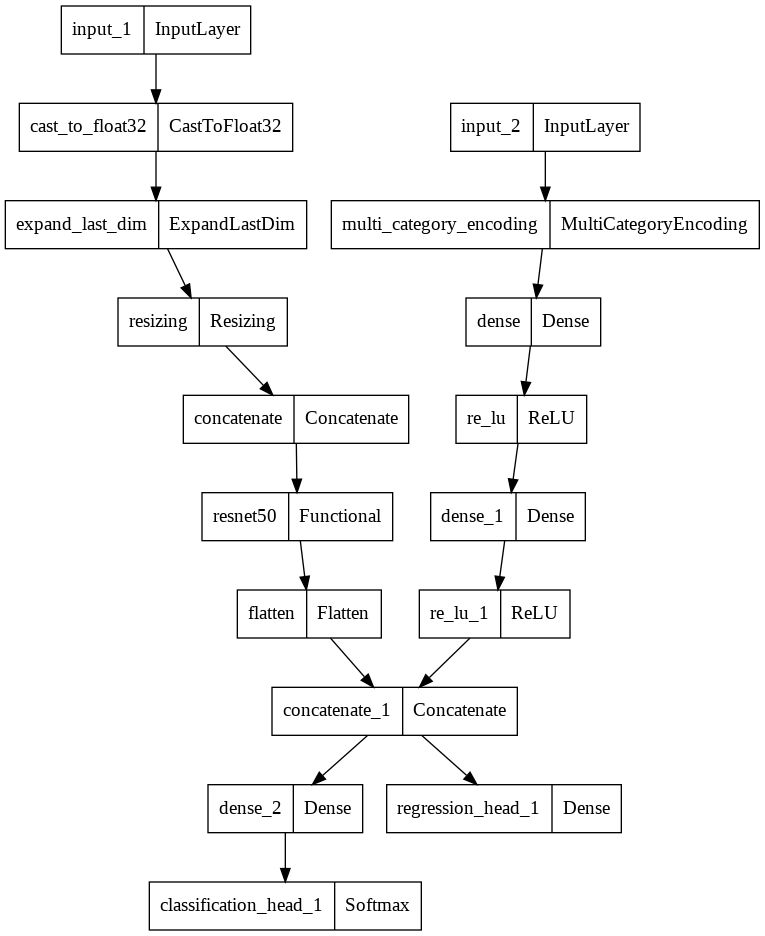

In [7]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [8]:
# Advanced Search

# 指定圖像處理部分用一般CNN,而非預設的ResNet
input_node1 = ak.ImageInput()
image_output = ak.ImageBlock(block_type='vanilla')(input_node1)

input_node2 = ak.StructuredDataInput()
structured_output = ak.StructuredDataBlock(normalize=True)(input_node2)

# 合併兩模型輸出
output_node = ak.Merge()([image_output, structured_output]) # ak.Merge Type(可指定add或concatenate)

# 產生模型的分類及迴歸結果
output_node1 = ak.ClassificationHead()(output_node)
output_node2 = ak.RegressionHead()(output_node)

multi_task = ak.AutoModel( 
    inputs=[input_node1, input_node2], 
    outputs=[output_node1, output_node2], 
    max_trials=5, overwrite=True)

multi_task.fit( 
    [image_data, structured_data], 
    [classification_target, regression_target], 
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=2)])

Trial 5 Complete [00h 03m 34s]
val_loss: 0.4398939907550812

Best val_loss So Far: 0.37628069519996643
Total elapsed time: 00h 15m 02s
INFO:tensorflow:Oracle triggered exit
18/18 [==============================] - 1s 9ms/step - loss: 3.1598 - classification_head_1_loss: 2.7803 - regression_head_1_loss: 0.3795 - classification_head_1_accuracy: 0.1195 - regression_head_1_mean_squared_error: 0.3795
INFO:tensorflow:Assets written to: ./auto_model/best_model/assets


In [10]:
model2 = multi_model.export_model()
model2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 8, 8)]       0           []                               
                                                                                                  
 cast_to_float32 (CastToFloat32  (None, 8, 8)        0           ['input_1[0][0]']                
 )                                                                                                
                                                                                                  
 expand_last_dim (ExpandLastDim  (None, 8, 8, 1)     0           ['cast_to_float32[0][0]']        
 )                                                                                                
                                                                                              

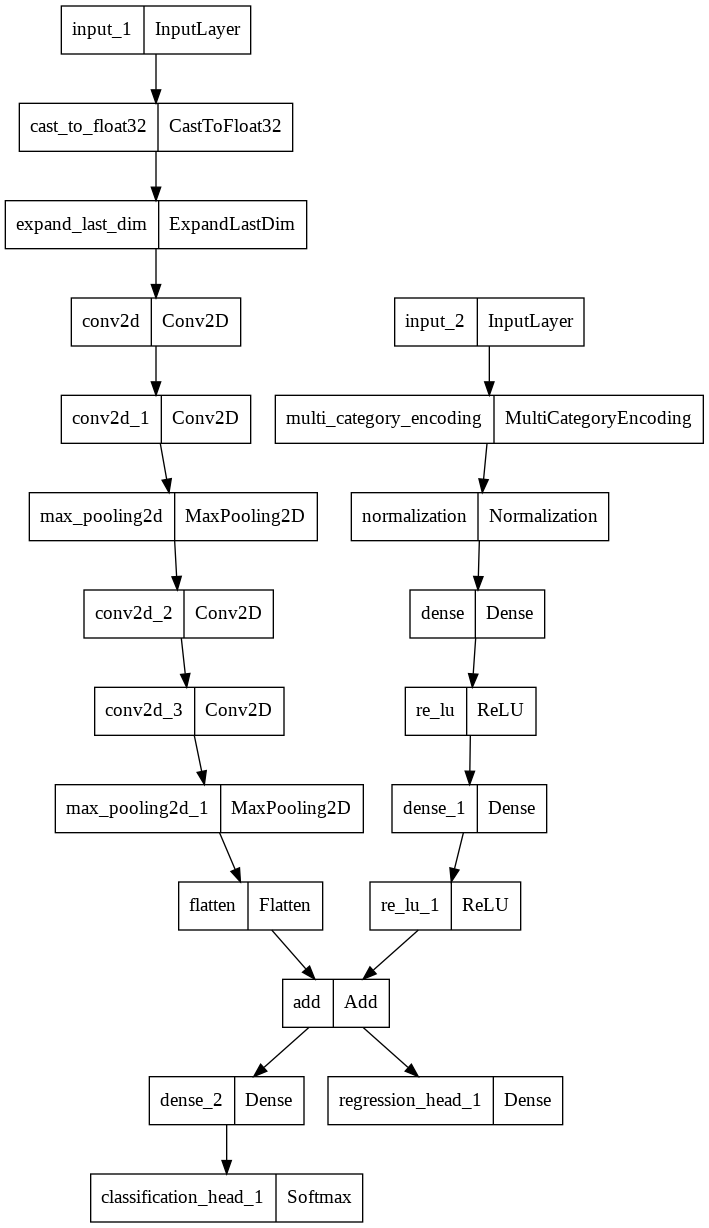

In [12]:
from tensorflow.keras.utils import plot_model
plot_model(model2)
# 模型架構變為簡單CNN, 且輸出合併方式改為add